### train

In [1]:
import multiprocessing
import threading
import tensorflow as tf
from agent.access import Access
from agent.main import Agent

In [2]:
NUMS_CPU = multiprocessing.cpu_count()
state_size = 58
batch_size = 50
action_size = 3
max_episodes = 1

In [3]:
GD = {}
class Worker(Agent):
    def __init__(self, name, access, batch_size, state_size, action_size):
        super().__init__(name, access, batch_size, state_size, action_size)

    def run(self, sess, max_episodes, t_max=8):
        episode_score_list = []
        episode = 0
        while episode < max_episodes:
            episode += 1
            episode_socre, _ = self.run_episode(sess, t_max)
            episode_score_list.append(episode_socre)
            GD[str(self.name)] = episode_score_list
            if self.name == 'W0':
                print('Episode: %f, score: %f' % (episode, episode_socre))
                print('\n')

In [4]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# with tf.Session(config=config) as sess:
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        A = Access(batch_size, state_size, action_size)
        F_list = []
        for i in range(NUMS_CPU):
            F_list.append(Worker('W%i' % i, A, batch_size, state_size, action_size))
        COORD = tf.train.Coordinator()
        sess.run(tf.global_variables_initializer())
        sess.graph.finalize()

        threads_list = []
        for ac in F_list:
            job = lambda: ac.run(sess, max_episodes)
            t = threading.Thread(target=job)
            t.start()
            threads_list.append(t)
        COORD.join(threads_list)
        A.save(sess, 'model/saver_1.ckpt')

C:\Users\Uekyo\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


graph W0
graph W1
graph W2
graph W3
graph W4
graph W5
graph W6
graph W7
actor: 0.443247, actor_grad: 0.089112, policy mean: 0.333333, policy: 0.454159, entropy: -1.091200, critic: 0.140194, critic_grad: 0.645205, value: 0.140194, value_mean: 0.054857, advantage: 0.415096
Episode: 1.000000, score: 0.987844




### test

In [5]:
tf.reset_default_graph()

In [6]:
import tensorflow as tf
from agent.access import Access
from agent.framework import Framework
from emulator.main import Account

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [7]:
state_size = 58
batch_size = 50
action_size = 3


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    with tf.device("/cpu:0"):
        A = Access(batch_size, state_size, action_size)
        W = Framework('W0', A, batch_size, state_size, action_size)
        A.restore(sess,'model/saver_1.ckpt')
        W.init_or_update_local(sess)
        env = Account()
        state = env.reset()
        for _ in range(200):
            action = W.get_deterministic_policy_action(sess, state)
            state, reward, done = env.step(action)

C:\Users\Uekyo\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


graph W0
INFO:tensorflow:Restoring parameters from model/saver_1.ckpt


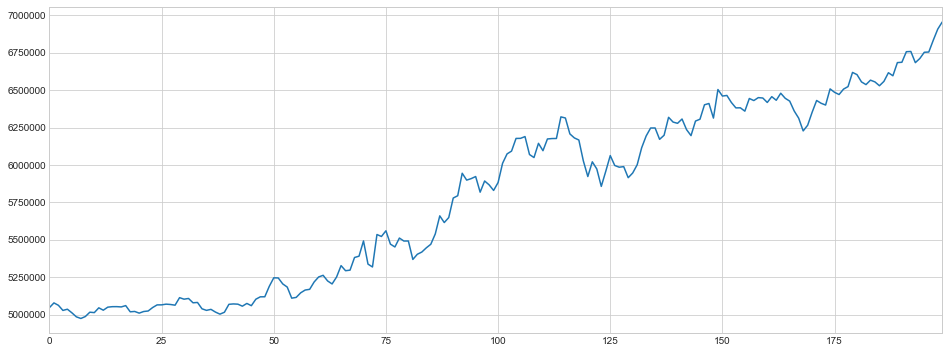

In [8]:
value, reward = env.plot_data()

pd.Series(value).plot(figsize=(16,6))

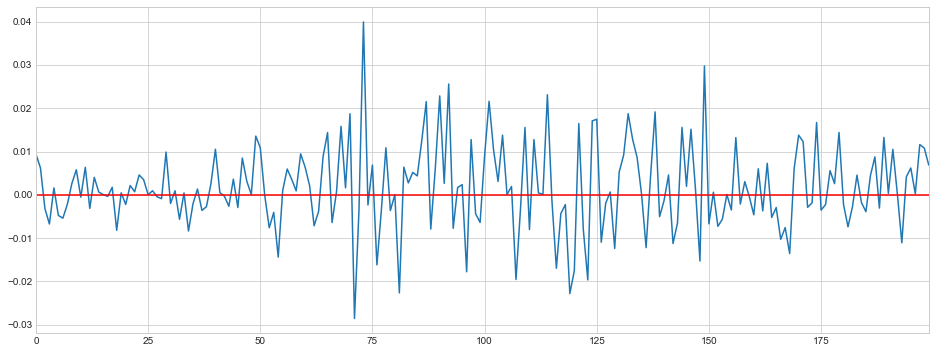

In [9]:
pd.Series(reward).plot(figsize=(16,6))
pd.Series(np.zeros_like(reward)).plot(figsize=(16,6), color='r')